In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import keras as keras
import keras_nlp
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import RobertaTokenizer, TFRobertaForSequenceClassification
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import AdamW

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import string, re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

print("TensorFlow version:", tf.__version__)
print("KerasNLP version:", keras_nlp.__version__)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


TensorFlow version: 2.18.0
KerasNLP version: 0.18.1


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [4]:
print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024**2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024**2))

Training Set Shape = (7613, 5)
Training Set Memory Usage = 0.29 MB
Test Set Shape = (3263, 4)
Test Set Memory Usage = 0.10 MB


In [5]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
df_train.shape

(7613, 5)

In [7]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
df_test.shape

(3263, 4)

In [9]:
print(df_train.isnull().sum())


id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [10]:
print(df_test.isnull().sum())


id             0
keyword       26
location    1105
text           0
dtype: int64


,count
target,
0,4342
1,3271


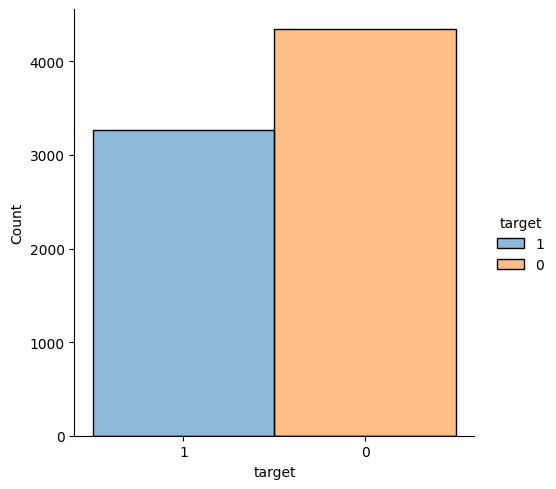

In [11]:
df_train['target'] = df_train['target'].astype(str)
sns.displot(data=df_train, x='target', hue='target')
df_train['target'].value_counts()

# Data Preprocessing

In [12]:
import nltk
nltk.download('punkt_tab')

def clean_text(txt):
    """""
    cleans the input text by following the steps:
    * replace contractions
    * remove punctuation
    * split into words
    * remove stopwords
    * remove leftover punctuations
    """""
    contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because",
                        "could've": "could have", "couldn't": "could not", "didn't": "did not",
                        "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not",
                        "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is",
                        "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have"}
    def _get_contractions(contraction_dict):
        contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
        return contraction_dict, contraction_re

    def replace_contractions(text):
        contractions, contractions_re = _get_contractions(contraction_dict)
        def replace(match):
            return contractions[match.group(0)]
        return contractions_re.sub(replace, text)

    # replace contractions
    txt = replace_contractions(txt)

    #remove punctuations
    txt  = "".join([char for char in txt if char not in string.punctuation])
    #remove numbers
    txt = re.sub('[0-9]+', '', txt)
    #txt = txt.str.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ", regex = True )
    txt = txt.lower() # lowercase  # Changed this line
    txt = re.sub(r"\#","", txt) # replaces hashtags # Changed this line
    txt = re.sub(r"http\S+","URL", txt)  # remove URL addresses # Changed this line
    txt = re.sub(r"@","", txt) # Changed this line
    txt = re.sub("\s{2,}", " ", txt) # remove multiple contiguous spaces # Changed this line

    # split into words
    words = word_tokenize(txt)

    # remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]

    # removing leftover punctuations
    words = [word for word in words if word.isalpha()]

    cleaned_text = ' '.join(words)
    return cleaned_text

# clean train and test tweets
df_train['text'] = df_train['text'].apply(lambda txt: clean_text(txt))
df_test['text'] = df_test['text'].apply(lambda txt: clean_text(txt))

df_train.head()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


# Exploratory Data Analysis (EDA)

creating a table to count how many times each keyword showing in the dataset

In [43]:
kw = df_train.keyword.value_counts().head(10).reset_index()
kw.columns=['keyword','frequency']

creating a table to count how many times each location showing in the dataset

In [44]:
loc = df_train.location.value_counts().head(10).reset_index()
loc.columns=['location','frequency']

creating a function to plot the frequence table

In [45]:
def plot_frequency(data,title):
    plt.figure(figsize=(10,6))
    plt.title('Most Frequent '+title,fontsize=20,fontweight='bold', pad=20)
    sns.barplot(x=title,y='frequency',data=data,palette='Set2')

<ipython-input-45-6a75c73faacd>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=title,y='frequency',data=data,palette='Set2')


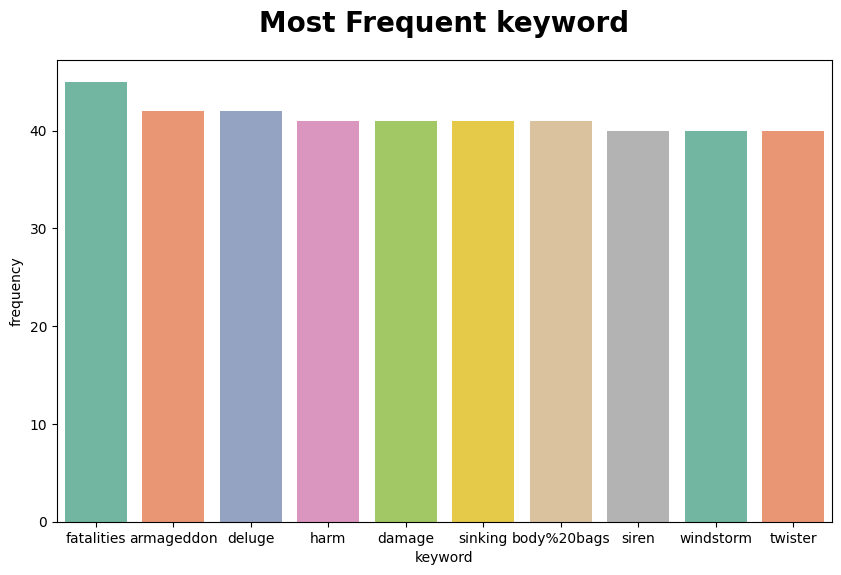

In [46]:
plot_frequency(kw,'keyword')

<ipython-input-45-6a75c73faacd>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=title,y='frequency',data=data,palette='Set2')


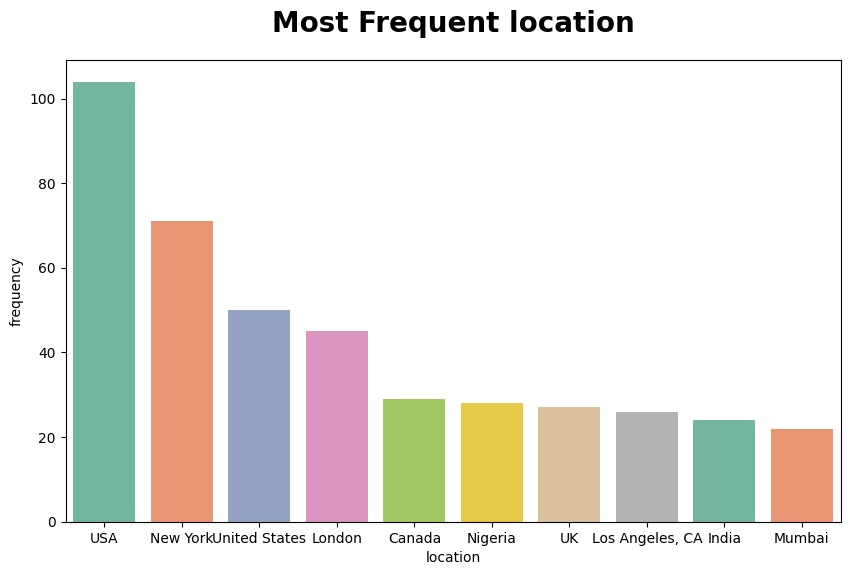

In [47]:
plot_frequency(loc,'location')

In [48]:
df_train.keyword.nunique()


221

creating a table to count the number of "label=1" by each keywords

In [49]:
imp = df_train.groupby('keyword').sum().reset_index().sort_values('target',ascending=False).head(20)

In [50]:
wdlist = list(imp.keyword)

creating a function to draw the word cloud


In [51]:
def getwordcloud(ls):
  word = ' '
  for i in range(len(ls)):
    word = word + ls[i] + ' '
  wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(word)
  plt.figure(figsize = (10, 5), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  plt.show()

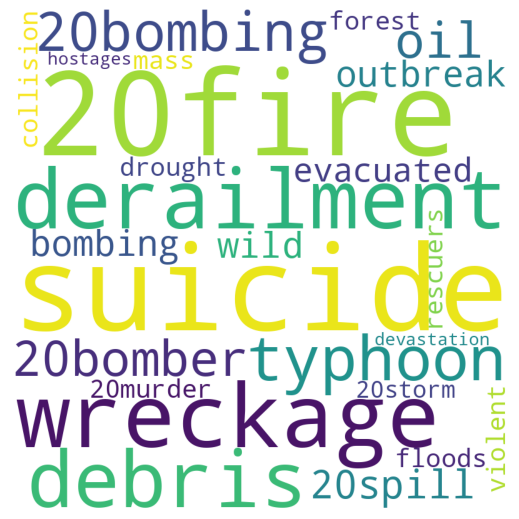

In [52]:
getwordcloud(wdlist)

### Does the presence of a keyword correlate with a higher likelihood of a disaster tweet


--- EDA: Keyword Presence vs. Target ---
target          0     1
has_keyword            
1            4342  3271

Percentages:
target               0          1
has_keyword                      
1            57.034021  42.965979


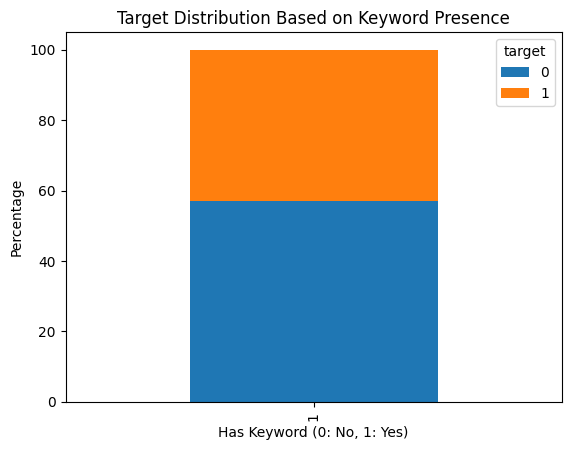

This shows if tweets *with* keywords are more likely to be about disasters.


In [53]:
print("\n--- EDA: Keyword Presence vs. Target ---")
df_train['has_keyword'] = df_train['keyword'].apply(lambda x: 0 if x == 'None' else 1)
keyword_presence_counts = df_train.groupby('has_keyword')['target'].value_counts().unstack()
print(keyword_presence_counts)

# Calculate percentages for better comparison
keyword_presence_percentages = keyword_presence_counts.div(keyword_presence_counts.sum(axis=1), axis=0) * 100
print("\nPercentages:")
print(keyword_presence_percentages)

keyword_presence_percentages.plot(kind='bar', stacked=True)
plt.title('Target Distribution Based on Keyword Presence')
plt.xlabel('Has Keyword (0: No, 1: Yes)')
plt.ylabel('Percentage')
plt.show()
print("This shows if tweets *with* keywords are more likely to be about disasters.")

Making Parameters

In [87]:
from tensorflow.keras.preprocessing import text # Import the 'text' module from keras.preprocessing
from tensorflow.keras.preprocessing import sequence # Import the 'sequence' module from keras.preprocessing
from sklearn.model_selection import train_test_split
import numpy as np



# Define parameters
max_len = 50  # Maximum sequence length  (choose based on your data analysis)
max_words = 10000  # Maximum number of words in vocabulary (adjust based on memory and performance)

# Split data for Tokenizer
xtrain, xval, ytrain, yval = train_test_split(df_train['text'].values, df_train['target'].values, shuffle=True, test_size=0.2)

# Create tokenizer and fit on training text
tokenizer = text.Tokenizer(num_words=max_words) # Use 'text.Tokenizer' since the 'text' module is imported
tokenizer.fit_on_texts(xtrain)

# Convert text to sequences
xtrain_seq = tokenizer.texts_to_sequences(xtrain)
xval_seq = tokenizer.texts_to_sequences(xval) #Use xval, not xtest.
# Pad sequences
xtrain_pad = sequence.pad_sequences(xtrain_seq, maxlen=max_len)  # Use 'sequence.pad_sequences' since the 'sequence' module is imported
xval_pad = sequence.pad_sequences(xval_seq, maxlen=max_len) #Use xval_pad, not xtest_pad.

# Convert to numpy arrays
xtrain_pad = np.array(xtrain_pad)
xval_pad = np.array(xval_pad)
ytrain = np.array(ytrain)
yval = np.array(yval)
# Reshape the input data for GRU and LSTM (samples, time steps, features)
X_train_gru = np.reshape(xtrain_pad, (xtrain_pad.shape[0], xtrain_pad.shape[1], 1))
X_val_gru = np.reshape(xval_pad, (xval_pad.shape[0], xval_pad.shape[1], 1))

X_train_lstm = np.reshape(xtrain_pad, (xtrain_pad.shape[0], xtrain_pad.shape[1], 1))
X_val_lstm = np.reshape(xval_pad, (xval_pad.shape[0], xval_pad.shape[1], 1))

ytrain = ytrain.astype(np.float32)
yval = yval.astype(np.float32)

# MODEL 1: BIDIRECTIONAL GRU




In [88]:
gru_model = Sequential()
gru_model.add(Bidirectional(GRU(32, dropout=0.2, recurrent_dropout=0.1), input_shape=(max_len, 1)))
gru_model.add(Dense(1, activation='sigmoid'))

gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print("--- BiDirectional GRU Model Summary ---")
gru_model.summary()


--- BiDirectional GRU Model Summary ---


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional)      │ (None, 64)                  │           6,720 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,785 (26.50 KB)

 Trainable params: 6,785 (26.50 KB)

 Non-trainable params: 0 (0.00 B)

In [89]:
gru_history = gru_model.fit(X_train_gru, ytrain, batch_size=128, epochs=15, validation_data=(X_val_gru, yval), verbose=2)

Epoch 1/15
48/48 - 19s - 388ms/step - accuracy: 0.5882 - loss: 0.6667 - val_accuracy: 0.6120 - val_loss: 0.6504
Epoch 2/15
48/48 - 20s - 408ms/step - accuracy: 0.6164 - loss: 0.6568 - val_accuracy: 0.6120 - val_loss: 0.6476
Epoch 3/15
48/48 - 12s - 256ms/step - accuracy: 0.6163 - loss: 0.6529 - val_accuracy: 0.6303 - val_loss: 0.6444
Epoch 4/15
48/48 - 13s - 273ms/step - accuracy: 0.6236 - loss: 0.6492 - val_accuracy: 0.6290 - val_loss: 0.6426
Epoch 5/15
48/48 - 20s - 413ms/step - accuracy: 0.6236 - loss: 0.6469 - val_accuracy: 0.6290 - val_loss: 0.6428
Epoch 6/15
48/48 - 20s - 426ms/step - accuracy: 0.6269 - loss: 0.6468 - val_accuracy: 0.6362 - val_loss: 0.6396
Epoch 7/15
48/48 - 20s - 413ms/step - accuracy: 0.6202 - loss: 0.6494 - val_accuracy: 0.6297 - val_loss: 0.6470
Epoch 8/15
48/48 - 20s - 427ms/step - accuracy: 0.6294 - loss: 0.6445 - val_accuracy: 0.6330 - val_loss: 0.6455
Epoch 9/15
48/48 - 20s - 420ms/step - accuracy: 0.6243 - loss: 0.6462 - val_accuracy: 0.6323 - val_loss:

In [91]:
# 4. Generate Predictions and Create Submission File
# --------------------------------------
# Generate predictions on the test set
# Preprocess the test data similar to training data
xtest_seq = tokenizer.texts_to_sequences(df_test['text'].values) # Preprocess test data
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_len) # Pad test data
X_test_gru = np.reshape(xtest_pad, (xtest_pad.shape[0], xtest_pad.shape[1], 1)) # Reshape for GRU

predictions = gru_model.predict(X_test_gru)

# Convert probabilities to binary predictions (0 or 1)
binary_predictions = (predictions > 0.5).astype(int)

# Create a Pandas DataFrame with the 'id' and 'target' columns
submission_df = pd.DataFrame({'id': df_test['id'], 'target': binary_predictions.flatten()})

# Save the DataFrame to a CSV file in the desired format
submission_df.to_csv('submissionGRU.csv', index=False)

print("Submission file 'submission.csv' created successfully.")

102/102 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step
Submission file 'submission.csv' created successfully.


# MODEL 2: BIDIRECTIONAL LSTM

In [97]:
lstm_model = Sequential()
lstm_model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True), input_shape=(max_len, 1)))  # No Embedding
lstm_model.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(1, activation='sigmoid'))

# Optimizer with a tuned learning rate
optimizer = Adam(learning_rate=0.001)

lstm_model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [98]:
print("\n--- BiDirectional LSTM Model Summary ---")
lstm_model.summary()


--- BiDirectional LSTM Model Summary ---


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_7 (Bidirectional)      │ (None, 50, 256)             │         133,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ (None, 128)                 │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 305,793 (1.17 MB)

 Trainable params: 305,793 (1.17 MB)

 Non-trainable params: 0 (0.00 B)

In [100]:
from tensorflow.keras.callbacks import EarlyStopping # Import EarlyStopping

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3) # Create an instance of EarlyStopping

# Fit the LSTM model with early stopping
lstm_history = lstm_model.fit(X_train_lstm, ytrain, batch_size=128, epochs=15,
                             validation_data=(X_val_lstm, yval), verbose=2,
                             callbacks=[early_stopping])

Epoch 1/15
48/48 - 46s - 963ms/step - accuracy: 0.5877 - loss: 0.6673 - val_accuracy: 0.6376 - val_loss: 0.6428
Epoch 2/15
48/48 - 38s - 784ms/step - accuracy: 0.6230 - loss: 0.6498 - val_accuracy: 0.6389 - val_loss: 0.6388
Epoch 3/15
48/48 - 29s - 608ms/step - accuracy: 0.6228 - loss: 0.6480 - val_accuracy: 0.6500 - val_loss: 0.6386
Epoch 4/15
48/48 - 44s - 912ms/step - accuracy: 0.6319 - loss: 0.6438 - val_accuracy: 0.6494 - val_loss: 0.6525
Epoch 5/15
48/48 - 41s - 864ms/step - accuracy: 0.6323 - loss: 0.6429 - val_accuracy: 0.6487 - val_loss: 0.6386
Epoch 6/15
48/48 - 37s - 772ms/step - accuracy: 0.6335 - loss: 0.6414 - val_accuracy: 0.6494 - val_loss: 0.6383
Epoch 7/15
48/48 - 30s - 617ms/step - accuracy: 0.6389 - loss: 0.6366 - val_accuracy: 0.6428 - val_loss: 0.6371
Epoch 8/15
48/48 - 29s - 596ms/step - accuracy: 0.6417 - loss: 0.6390 - val_accuracy: 0.6395 - val_loss: 0.6442
Epoch 9/15
48/48 - 42s - 883ms/step - accuracy: 0.6455 - loss: 0.6352 - val_accuracy: 0.6382 - val_loss:

In [101]:
# 6. Evaluate and get insights: AUC and Accuracy
# --------------------------------------

from sklearn.metrics import roc_auc_score, accuracy_score

# Predicting probabilities for the test set
y_pred_proba = lstm_model.predict(X_val_lstm)

# Calculating AUC
auc = roc_auc_score(yval, y_pred_proba)
print(f"\nAUC: {auc:.4f}")

# Convert probabilities to binary predictions (0 or 1)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Calculate accuracy
accuracy = accuracy_score(yval, y_pred_binary)
print(f"Accuracy: {accuracy:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 133ms/step

AUC: 0.6763
Accuracy: 0.6435


In [103]:
# 4. Generate Predictions and Create Submission File
# --------------------------------------
# Generate predictions on the test set

# Preprocess the test data similar to training data
xtest_seq = tokenizer.texts_to_sequences(df_test['text'].values) # Preprocess test data
xtest_pad = sequence.pad_sequences(xtest_seq, maxlen=max_len) # Pad test data
X_test_lstm = np.reshape(xtest_pad, (xtest_pad.shape[0], xtest_pad.shape[1], 1)) # Reshape for LSTM


predictions = lstm_model.predict(X_test_lstm)

# Convert probabilities to binary predictions (0 or 1)
binary_predictions = (predictions > 0.5).astype(int)

# Create a Pandas DataFrame with the 'id' and 'target' columns
submission_df = pd.DataFrame({'id': df_test['id'], 'target': binary_predictions.flatten()}) # Use df_test instead of test_df

# Save the DataFrame to a CSV file in the desired format
submission_df.to_csv('submissionLSTM.csv', index=False)

print("Submission file 'submission.csv' created successfully.")

102/102 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step
Submission file 'submission.csv' created successfully.


# MODEL 3: roBERTa

In [107]:
df_train["length"] = df_train["text"].apply(lambda x : len(x))
df_test["length"] = df_test["text"].apply(lambda x : len(x))

print("Train Length Stat")
print(df_train["length"].describe())
print()

print("Test Length Stat")
print(df_test["length"].describe())

Train Length Stat
count    7613.000000
mean       65.609352
std        24.398309
min         3.000000
25%        48.000000
50%        67.000000
75%        85.000000
max       138.000000
Name: length, dtype: float64

Test Length Stat
count    3263.000000
mean       66.618756
std        24.516050
min         0.000000
25%        49.000000
50%        69.000000
75%        86.000000
max       125.000000
Name: length, dtype: float64


In [108]:
from sklearn.model_selection import train_test_split

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test = df_test["text"]

In [104]:
# Robust BERT
# Load RoBERTa tokenizer
MODEL_NAME = "roberta-base"
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [109]:
import tensorflow as tf # Make sure TensorFlow is imported
from transformers import RobertaTokenizer

In [110]:
def tokenize_data(texts, labels, max_length=128):
    """
    Tokenizes text data using the RobertaTokenizer.
    """
    # Convert NumPy array to list of strings if necessary
    if isinstance(texts, np.ndarray):
        texts = texts.tolist()
    # If elements in the list are not strings, convert them to strings
    texts = [str(text) for text in texts]
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length, return_tensors="tf")
    return encodings, tf.convert_to_tensor(labels, dtype=tf.int32)

In [111]:
train_encodings, train_labels = tokenize_data(X_train, y_train)
test_encodings, test_labels = tokenize_data(X_val, y_val)

In [112]:
from transformers import TFRobertaForSequenceClassification, create_optimizer
from tensorflow.keras.optimizers.schedules import PolynomialDecay

# ✅ Load Pretrained RoBERTa Model
MODEL_NAME = "roberta-base"
model = TFRobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=1)  # Set to 1 for binary classification

# ✅ Define Training Parameters
batch_size = 36
num_epochs = 10
steps_per_epoch = len(X_train) // batch_size
total_steps = steps_per_epoch * num_epochs

# ✅ Create Optimizer
optimizer, _ = create_optimizer(
    init_lr=5e-6,
    num_train_steps=total_steps,
    num_warmup_steps=int(0.1 * total_steps),
    weight_decay_rate=0.01
)

# ✅ Compile Model with BinaryCrossentropy
model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # ✅ Correct loss function for binary classification
    metrics=["accuracy"]
)

# ✅ Train Model
model.fit(
    x={"input_ids": train_encodings["input_ids"], "attention_mask": train_encodings["attention_mask"]},
    y=train_labels,  # Ensure labels are shape (num_samples, 1)
    validation_data=(
        {"input_ids": test_encodings["input_ids"], "attention_mask": test_encodings["attention_mask"]},
        test_labels,
    ),
    batch_size=batch_size,
    epochs=num_epochs
)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

Epoch 1/10
170/170 [==============================] - 90s 387ms/step - loss: 0.6289 - accuracy: 0.6171 - val_loss: 0.4415 - val_accuracy: 0.8168
Epoch 2/10
170/170 [==============================] - 62s 363ms/step - loss: 0.4271 - accuracy: 0.8141 - val_loss: 0.4414 - val_accuracy: 0.8227
Epoch 3/10
170/170 [==============================] - 62s 364ms/step - loss: 0.3855 - accuracy: 0.8378 - val_loss: 0.4102 - val_accuracy: 0.8306
Epoch 4/10
170/170 [==============================] - 62s 364ms/step - loss: 0.3551 - accuracy: 0.8558 - val_loss: 0.4486 - val_accuracy: 0.8293
Epoch 5/10
170/170 [==============================] - 62s 364ms/step - loss: 0.3244 - accuracy: 0.8670 - val_loss: 0.4371 - val_accuracy: 0.8273
Epoch 6/10
170/170 [==============================] - 62s 364ms/step - loss: 0.3107 - accuracy: 0.8765 - val_loss: 0.4935 - val_accuracy: 0.8247
Epoch 7/10
170/170 [==============================] - 60s 356ms/step - loss: 0.2915 - accuracy: 0.8874 - val_loss: 0.4831 - val_ac

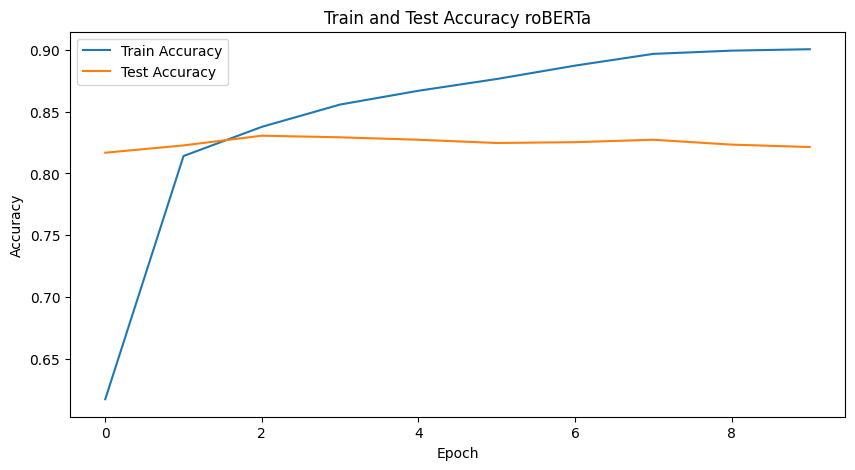

In [113]:
plt.figure(figsize=(10, 5))
plt.plot(model.history.history['accuracy'], label='Train Accuracy')
plt.plot(model.history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Test Accuracy roBERTa')
plt.show()

In [114]:
y_pred_logits = model.predict({"input_ids": test_encodings["input_ids"], "attention_mask": test_encodings["attention_mask"]})
y_pred_probs = tf.nn.sigmoid(y_pred_logits.logits).numpy()

48/48 [==============================] - 10s 94ms/step


In [115]:
y_pred_labels = (y_pred_probs > 0.5).astype(int).flatten()

F1 Score: 0.7845220030349014
F1 Score: 0.7845220030349014


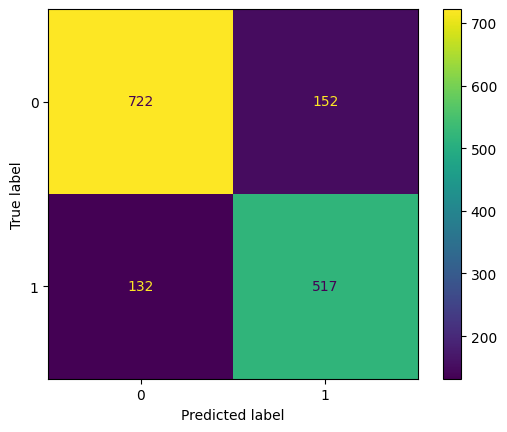

In [117]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# Convert y_val to numeric type
y_val = y_val.astype(int)

# Calculate the F1 score
f1 = f1_score(y_val, y_pred_labels)
print(f"F1 Score: {f1}")

# Calculate the F1 score
f1 = f1_score(y_val, y_pred_labels)
print(f"F1 Score: {f1}")

# Create the confusion matrix
cm = confusion_matrix(y_val, y_pred_labels)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [121]:
# --------------------------------------
# 1. Tokenize test data using the same tokenizer
# --------------------------------------

# 🐛 Fix: Call the tokenizer directly with X_test
# ✅ Pass only the test text data (X_test) to the tokenizer
test_encodings = tokenizer(
    X_test.tolist(),  # Convert to list if necessary
    truncation=True,
    padding=True,
    max_length=128,  # Adjust max_length if needed
    return_tensors="tf"
)
# --------------------------------------
# 2. Make predictions on test data
# --------------------------------------

# Predict raw logits from the model
test_predictions = model.predict({
    "input_ids": test_encodings["input_ids"],
    "attention_mask": test_encodings["attention_mask"]
})

# Apply sigmoid to get probabilities
test_predictions_sigmoid = tf.nn.sigmoid(test_predictions.logits).numpy()

# Convert probabilities to binary predictions
test_pred_labels = (test_predictions_sigmoid > 0.5).astype(int).flatten()

# --------------------------------------
# 3. Create submission DataFrame
# --------------------------------------

submission_df = pd.DataFrame({
    "id": df_test["id"],
    "target": test_pred_labels
})

# --------------------------------------
# 4. Save submission DataFrame to CSV
# --------------------------------------

submission_df.to_csv("submissionROBERTA.csv", index=False)

print("Submission file 'submissionROBERTA.csv' created successfully.")

102/102 [==============================] - 13s 126ms/step
Submission file 'submissionROBERTA.csv' created successfully.


# MODEL 4: deBERTa

In [13]:
# Decoder deBERT

from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, create_optimizer

In [14]:
MODEL_NAME = "microsoft/deberta-v3-base"

#Load Tokenizer
tokenizer_deberta = AutoTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [15]:
def tokenize_deberta(texts, labels, max_length=128):
    encodings = tokenizer_deberta(texts.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors="tf")
    return encodings, tf.convert_to_tensor(labels, dtype=tf.int32)

In [16]:
# Before you run cell 15 you should have:

from sklearn.model_selection import train_test_split

# Assuming df_train is your DataFrame with 'text' and 'target' columns:

X = df_train["text"]
y = df_train["target"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42) # Or any random state

# Now you can proceed to the cell 15 and later

train_encodings_deberta, train_labels_deberta = tokenize_deberta(X_train, y_train)
test_encodings_deberta, test_labels_deberta = tokenize_deberta(X_val, y_val)

In [17]:
# ✅ Load Pretrained DeBERTa Model for Binary Classification
model_deberta = TFAutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=1)  # num_labels=1 for BCE Loss

# ✅ Learning Rate Schedule
batch_size = 8
num_epochs = 5
steps_per_epoch = len(X_train) // batch_size
total_steps = steps_per_epoch * num_epochs

optimizer, _ = create_optimizer(
    init_lr=2e-5,  # Initial Learning Rate
    num_train_steps=total_steps,
    num_warmup_steps=int(0.1 * total_steps),
    weight_decay_rate=0.01
)

# ✅ Compile Model
model_deberta.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),  # BCE Loss for single output
    metrics=["accuracy"]
)

tf_model.h5:   0%|          | 0.00/736M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFDebertaV2ForSequenceClassification.

Some layers of TFDebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['cls_dropout', 'pooler', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
model_deberta.fit(
    x={"input_ids": train_encodings_deberta["input_ids"], "attention_mask": train_encodings_deberta["attention_mask"]},
    y=train_labels_deberta,  # Ensure labels are shape (num_samples, 1)
    validation_data=(
        {"input_ids": test_encodings_deberta["input_ids"], "attention_mask": test_encodings_deberta["attention_mask"]},
        test_labels_deberta,
    ),
    batch_size=batch_size,
    epochs=num_epochs
)

Epoch 1/5


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


762/762 [==============================] - 256s 267ms/step - loss: 0.5182 - accuracy: 0.7300 - val_loss: 0.4808 - val_accuracy: 0.8194
Epoch 2/5
762/762 [==============================] - 198s 259ms/step - loss: 0.3947 - accuracy: 0.8366 - val_loss: 0.4024 - val_accuracy: 0.8109
Epoch 3/5
762/762 [==============================] - 195s 256ms/step - loss: 0.3352 - accuracy: 0.8657 - val_loss: 0.3904 - val_accuracy: 0.8352
Epoch 4/5
762/762 [==============================] - 196s 258ms/step - loss: 0.2760 - accuracy: 0.8951 - val_loss: 0.4443 - val_accuracy: 0.8345
Epoch 5/5
762/762 [==============================] - 197s 258ms/step - loss: 0.2252 - accuracy: 0.9186 - val_loss: 0.4675 - val_accuracy: 0.8359


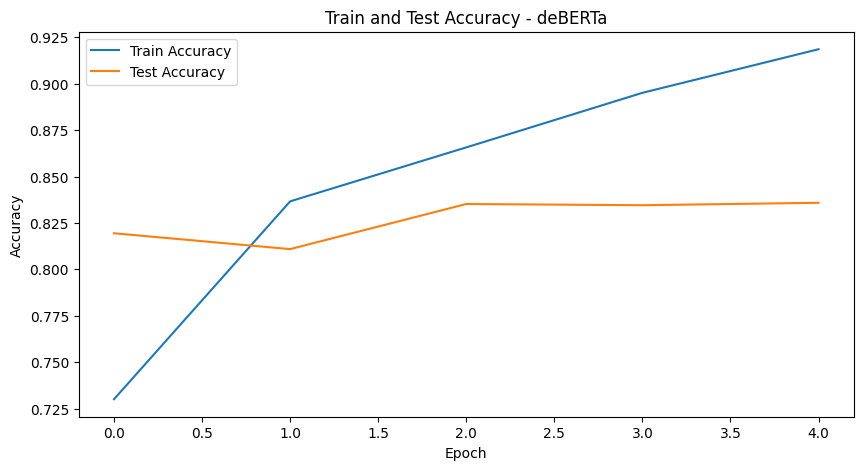

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(model_deberta.history.history['accuracy'], label='Train Accuracy') # Access history data using history.history
plt.plot(model_deberta.history.history['val_accuracy'], label='Test Accuracy') # Access history data using history.history
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and Test Accuracy - deBERTa')
plt.show()

In [21]:
y_deberta_logits = model_deberta.predict({"input_ids": test_encodings_deberta["input_ids"], "attention_mask": test_encodings_deberta["attention_mask"]})
y_deberta_probs = tf.nn.sigmoid(y_deberta_logits.logits).numpy()
y_deberta_labels = (y_deberta_probs > 0.5).astype(int).flatten()

48/48 [==============================] - 12s 115ms/step


F1 Score: 0.7943262411347518


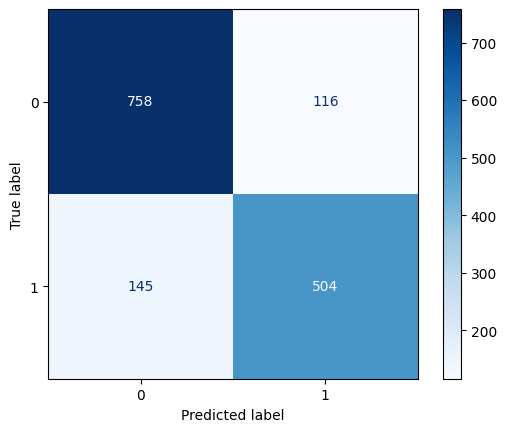

In [23]:
# Convert y_val to numeric type before calculating metrics
y_val = y_val.astype(int)

# Calculate the F1 score
f1 = f1_score(y_val, y_deberta_labels)
print(f"F1 Score: {f1}")

# Create the confusion matrix
cm = confusion_matrix(y_val, y_deberta_labels)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [27]:
# Get the predictions for the test data, not validation data.

# Tokenize test data using the DeBERTa tokenizer
test_encodings_deberta = tokenizer_deberta(df_test["text"].tolist(), truncation=True, padding=True, max_length=128, return_tensors="tf")

# Predict on test data using model_deberta
y_deberta_logits = model_deberta.predict({"input_ids": test_encodings_deberta["input_ids"], "attention_mask": test_encodings_deberta["attention_mask"]})
y_deberta_probs = tf.nn.sigmoid(y_deberta_logits.logits).numpy()
y_deberta_labels = (y_deberta_probs > 0.5).astype(int).flatten()

# Continue creating the submission DataFrame
submission_df = pd.DataFrame({
    "id": df_test["id"],
    "target": y_deberta_labels
})

submission_df.to_csv("submission_deBERTa.csv", index=False)

print("Submission file 'submission.csv' created successfully.")

102/102 [==============================] - 27s 148ms/step
Submission file 'submission.csv' created successfully.


# distilBERT

In [28]:
# distilBERT
BATCH_SIZE = 32
NUM_TRAINING_EXAMPLES = df_train.shape[0]
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.2
STEPS_PER_EPOCH = int(NUM_TRAINING_EXAMPLES)*TRAIN_SPLIT // BATCH_SIZE

EPOCHS = 10
AUTO = tf.data.experimental.AUTOTUNE

In [29]:
# Load a DistilBERT model.
preset= "distil_bert_base_en_uncased"

# Use a shorter sequence length.
preprocessor = keras_nlp.models.DistilBertPreprocessor.from_preset(preset,
                                                                   sequence_length=160,
                                                                   name="preprocessor_4_tweets"
                                                                  )

# Pretrained classifier.
classifier = keras_nlp.models.DistilBertClassifier.from_preset(preset,
                                                               preprocessor = preprocessor,
                                                               num_classes=2)

classifier.summary()

100%|██████████| 515/515 [00:00<00:00, 1.16MB/s]


100%|██████████| 580/580 [00:00<00:00, 681kB/s]


100%|██████████| 226k/226k [00:00<00:00, 1.19MB/s]


100%|██████████| 253M/253M [00:04<00:00, 59.1MB/s]


Preprocessor: "preprocessor_4_tweets"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ distil_bert_tokenizer (DistilBertTokenizer)                   │                       Vocab size: 30,522 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "distil_bert_text_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ distil_bert_backbone          │ (None, None, 768)         │      66,362,880 │ padding_mask[0][0],        │
│ (DistilBertBackbone)          │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ get_item (GetItem)            │ (None, 768)               │               0 │ distil_bert_backbone[0][0] │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooled_dense (Dense)          │ (None, 768)               │         590,592 │ get_item[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output_dropout (Dropout)      │ (None, 768)               │               0 │ pooled_dense[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logits (Dense)                │ (None, 2)                 │           1,538 │ output_dropout[0][0]       │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 66,955,010 (255.41 MB)

 Trainable params: 66,955,010 (255.41 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
# Compile
classifier.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), #'binary_crossentropy',
    optimizer=keras.optimizers.Adam(1e-6),
    metrics= ["accuracy"]
)

# Convert X_train and y_train to TensorFlow tensors
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.string)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.int32)

# Convert X_val and y_val to TensorFlow tensors
X_val_tensor = tf.convert_to_tensor(X_val, dtype=tf.string)
y_val_tensor = tf.convert_to_tensor(y_val, dtype=tf.int32)

# Fit
history = classifier.fit(x=X_train_tensor, # Pass the TensorFlow tensors
                         y=y_train_tensor, # Pass the TensorFlow tensors
                         batch_size=BATCH_SIZE,
                         epochs=EPOCHS,
                         validation_data=(X_val_tensor, y_val_tensor) # Pass the TensorFlow tensors
                        )

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 173s 662ms/step - accuracy: 0.5007 - loss: 0.6926 - val_accuracy: 0.6894 - val_loss: 0.6416
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 158s 550ms/step - accuracy: 0.7099 - loss: 0.6202 - val_accuracy: 0.7892 - val_loss: 0.5256
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 142s 549ms/step - accuracy: 0.7985 - loss: 0.5115 - val_accuracy: 0.7951 - val_loss: 0.4658
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 139s 535ms/step - accuracy: 0.8091 - loss: 0.4568 - val_accuracy: 0.7945 - val_loss: 0.4514
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 104s 546ms/step - accuracy: 0.8162 - loss: 0.4368 - val_accuracy: 0.7978 - val_loss: 0.4433
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 104s 544ms/step - accuracy: 0.8341 - loss: 0.4127 - val_accuracy: 0.8024 - val_loss: 0.4372
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 102s 531ms/step - accuracy: 0.8287 - loss: 0.4068 - val_accuracy: 0.8030 - val_loss: 0.4342
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 101s 530ms/step - accuracy: 0.8407 -

In [37]:
def displayConfusionMatrix(y_true, y_pred, dataset):
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true,
        np.argmax(y_pred, axis=1),
        display_labels=["Not Disaster","Disaster"],
        cmap=plt.cm.Blues
    )

    tn, fp, fn, tp = confusion_matrix(y_true, np.argmax(y_pred, axis=1)).ravel()
    f1_score = tp / (tp+((fn+fp)/2))

    disp.ax_.set_title("Confusion Matrix on " + dataset + " Dataset -- F1 Score: " + str(f1_score.round(2)))

191/191 ━━━━━━━━━━━━━━━━━━━━ 33s 172ms/step


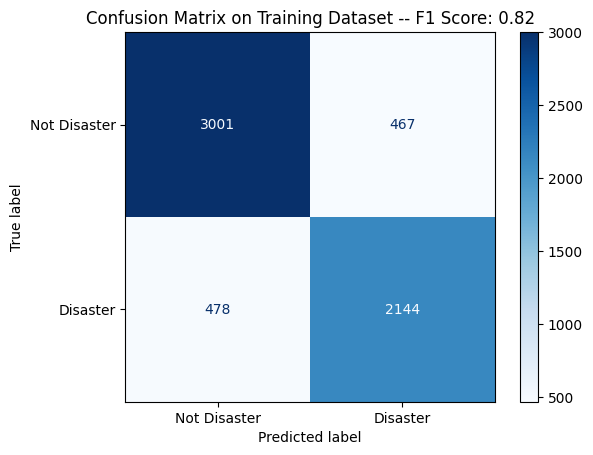

In [39]:
y_pred_train = classifier.predict(X_train)

# Convert y_train to numeric type before calling displayConfusionMatrix
y_train_numeric = y_train.astype(int)

displayConfusionMatrix(y_train_numeric, y_pred_train, "Training")

48/48 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step


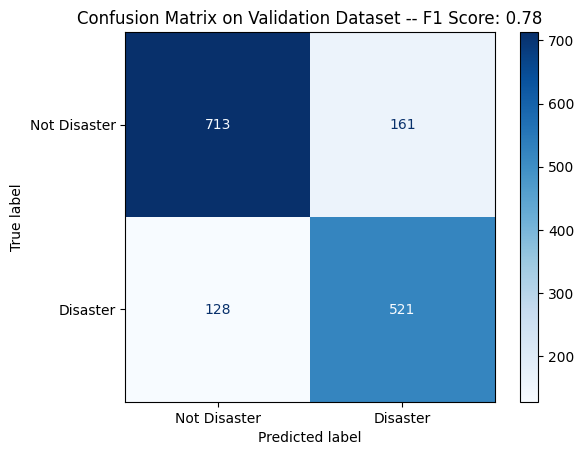

In [40]:
y_pred_val = classifier.predict(X_val)

displayConfusionMatrix(y_val, y_pred_val, "Validation")

In [42]:
submit = pd.DataFrame()

# Extract the 'text' column from df_test and convert it to a TensorFlow tensor
X_test = tf.convert_to_tensor(df_test['text'].values, dtype=tf.string)

y_test_pred = classifier.predict(X_test)  # Now X_test is defined
submit['target'] = np.argmax(y_test_pred, axis=1)
submit['id'] = df_test['id']
submit.to_csv('submission_distilBERT.csv', index=False)

102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 205ms/step
